In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv("./天气数据/china_sites_20211201.csv")

In [3]:
df=df[['date','hour','type','1145A']]

In [4]:
air_indexs=[v[0] for v in df.groupby("type")]
print(",".join(air_indexs))

AQI,CO,CO_24h,NO2,NO2_24h,O3,O3_24h,O3_8h,O3_8h_24h,PM10,PM10_24h,PM2.5,PM2.5_24h,SO2,SO2_24h


In [5]:
df_reshape=pd.DataFrame(columns=["date","hour"]+air_indexs)

In [6]:
for i in range(1,32):
    df=pd.read_csv(f"./天气数据/china_sites_202112{i:0>2d}.csv")
    df=df[['date','hour','type','1145A']]
    date=df.loc[0,'date']
    for v in df.groupby("hour"):
        a=np.array([date,v[0]])
        b=np.r_[a,v[1].T.iloc[-1].values]
        df_reshape=df_reshape.append(pd.Series(b,index=df_reshape.columns),ignore_index=True)
df=df_reshape
df.to_csv("杨浦空气数据.csv")

In [7]:
X=df[air_indexs].dropna()
X

,AQI,CO,CO_24h,NO2,NO2_24h,O3,O3_24h,O3_8h,O3_8h_24h,PM10,PM10_24h,PM2.5,PM2.5_24h,SO2,SO2_24h
0,65.0,42.0,46.0,80.0,68.0,6.0,5.0,30.0,34.0,50.0,70.0,53.0,58.0,0.6,0.8
1,58.0,34.0,47.0,66.0,71.0,5.0,5.0,26.0,33.0,53.0,70.0,53.0,53.0,0.5,0.8
2,48.0,24.0,47.0,48.0,72.0,5.0,5.0,25.0,32.0,51.0,70.0,52.0,53.0,0.5,0.8
3,42.0,18.0,47.0,42.0,73.0,6.0,5.0,27.0,31.0,46.0,70.0,50.0,53.0,0.5,0.8
4,39.0,16.0,45.0,39.0,72.0,6.0,5.0,29.0,31.0,41.0,63.0,48.0,53.0,0.5,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,28.0,16.0,55.0,28.0,67.0,5.0,10.0,38.0,81.0,67.0,88.0,74.0,74.0,0.7,1.4
732,23.0,11.0,53.0,21.0,64.0,5.0,9.0,31.0,77.0,72.0,88.0,76.0,76.0,0.6,1.3
733,21.0,10.0,50.0,18.0,61.0,5.0,9.0,42.0,73.0,60.0,88.0,74.0,76.0,0.6,1.3
734,26.0,11.0,47.0,18.0,57.0,5.0,8.0,51.0,70.0,49.0,88.0,69.0,76.0,0.6,1.2


In [8]:
X=X.values
X

array([[65. , 42. , 46. , ..., 58. ,  0.6,  0.8],
       [58. , 34. , 47. , ..., 53. ,  0.5,  0.8],
       [48. , 24. , 47. , ..., 53. ,  0.5,  0.8],
       ...,
       [21. , 10. , 50. , ..., 76. ,  0.6,  1.3],
       [26. , 11. , 47. , ..., 76. ,  0.6,  1.2],
       [24. , 10. , 44. , ..., 76. ,  0.6,  1.2]])

In [9]:
Xstd=X.std(axis=0)
Xavg=X.mean(axis=0)
X=(X-Xavg)/Xstd   #Z-score
# X=(X-X.min(axis=0))/(X.max(axis=0)-X.min(axis=0)) #Min-Max
# X=(X-Xavg) #中心化
Xcoeff=np.corrcoef(X.T)
X.shape

(704, 15)

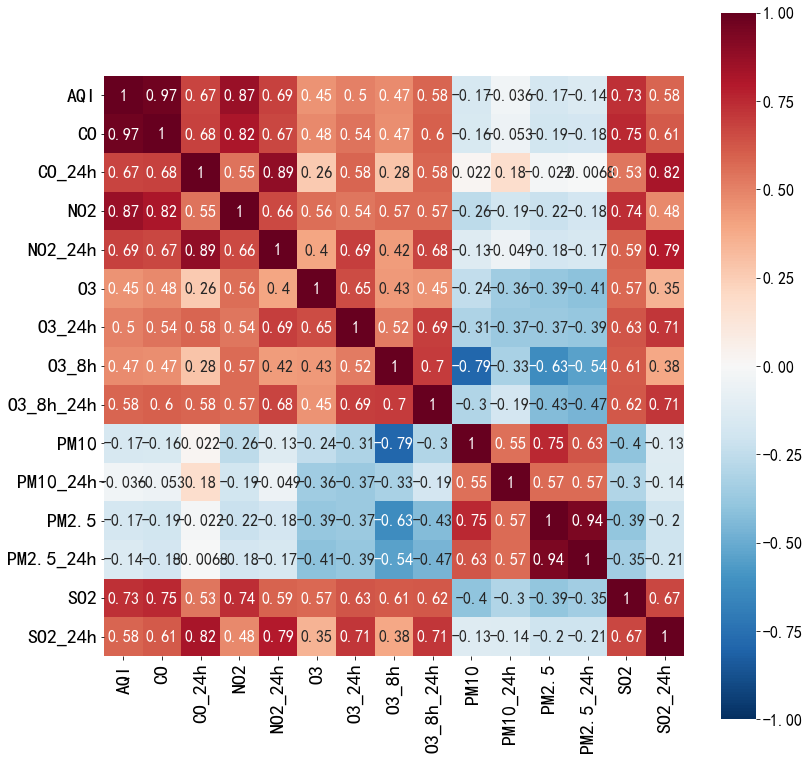

In [10]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['font.size'] = 16
columns=air_indexs
#协方差图
plt.subplots(figsize=(13,13))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.heatmap(Xcoeff, annot=True, vmax=1,vmin=-1, square=True, cmap='RdBu_r',xticklabels=columns,yticklabels=columns,)
plt.show()

In [11]:
#KMO检验
def kmo(dataset_corr):
    corr_inv = np.linalg.inv(dataset_corr)
    nrow_inv_corr, ncol_inv_corr = dataset_corr.shape
    A = np.ones((nrow_inv_corr,ncol_inv_corr))
    for i in range(0,nrow_inv_corr,1):
        for j in range(i,ncol_inv_corr,1):
            A[i,j] = -(corr_inv[i,j])/(np.sqrt(corr_inv[i,i]*corr_inv[j,j]))
            A[j,i] = A[i,j]
    dataset_corr = np.asarray(dataset_corr)
    kmo_num = np.sum(np.square(dataset_corr)) - np.sum(np.square(np.diagonal(A)))
    kmo_denom = kmo_num + np.sum(np.square(A)) - np.sum(np.square(np.diagonal(A)))
    kmo_value = kmo_num / kmo_denom
    return kmo_value
kmo(np.corrcoef(X.T))

0.7982312568818896

In [12]:
#Bartlett检验
from scipy.stats import bartlett
bartlett(*[np.corrcoef(X.T)[i,:] for i in range(X.T.shape[0])])

BartlettResult(statistic=6.391159617557155, pvalue=0.9556490786073009)

![图像](./指标.png)
 
## 结论  

+ 相关系数矩阵看起来不错(p>0.7)
+ KMO检验 0.8 
+ Bartlett检验值 0.95,接近1
**这一个数据集可以进行因子分析**

因子编号，特征值，累计贡献率
0     , 3.4514    , 0.5102
1     , 1.0688    , 0.7142
2     , 0.0275    , 0.7844
3     , -0.0560   , 0.8439
4     , -0.2255   , 0.8816
5     , -0.2469   , 0.9165
6     , -0.3350   , 0.9401
7     , -0.3513   , 0.9616
8     , -0.4134   , 0.9752
9     , -0.4468   , 0.9844
10    , -0.4740   , 0.9902
11    , -0.4918   , 0.9937
12    , -0.4969   , 0.9965
13    , -0.5010   , 0.9988
14    , -0.5091   , 1.0000


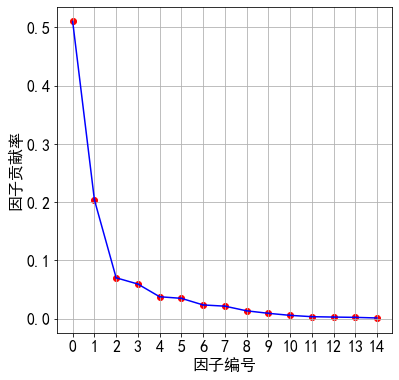

5


In [13]:
#PCA
Xcov=np.dot(X.T,X)
a, b = np.linalg.eig(Xcov) #求特征值，特征向量
order_des=a.argsort()[::-1] 
lambda_sorted=a[order_des] #对特征值排序

#也可以用svd分解去做，还可以直接调scipy 具体原理请参阅pca

#查看特征值和累计贡献率
topFactorIndex=0
sigma_lambda_sorted=0

print(f"因子编号，特征值，累计贡献率")
stair_data=np.zeros(shape=(lambda_sorted.shape[0],2))
for i in range(lambda_sorted.shape[0]):
    sigma_lambda_sorted+=lambda_sorted[i]
    if sigma_lambda_sorted/np.sum(lambda_sorted)>=0.90 and topFactorIndex==0:
        topFactorIndex=i
    print(f"{i:<6d}, {(lambda_sorted[i]-np.mean(lambda_sorted))/np.std(lambda_sorted):<10.4f}, {sigma_lambda_sorted/np.sum(lambda_sorted):.4f}")
    stair_data[i]=[i,lambda_sorted[i]/np.sum(lambda_sorted)]

plt.subplots(figsize=(6,6))
plt.grid(True)
plt.xticks(stair_data[:,0])
plt.yticks()
plt.xlabel("因子编号")
plt.ylabel("因子贡献率")
for i in range(lambda_sorted.shape[0]-1):
    plt.plot(stair_data[i:i+2,0],stair_data[i:i+2,1],c='b')
plt.scatter(x=stair_data[:,0],y=stair_data[:,1],c='r')
plt.show()

print(topFactorIndex)

### 选取5个因子

In [14]:
# 前N个Factor的特征值、特征向量
# topFactorIndex= 
lambda_sorted=lambda_sorted/np.sum(lambda_sorted**2)**0.5
a_=lambda_sorted[:topFactorIndex]
v_=b[order_des][:topFactorIndex]
X_new=np.dot(X,v_.T) #投影到新的坐标系
A=a_**0.5*v_.T #因子荷载矩阵

In [15]:
# 格式化输出X=AF+B
for i in range(A.shape[0]):
    _str=f"X{i:<4d}="
    for j in range(A.shape[1]):
        _str+=f" + {A[i,j]: .4f}*F{j}"
    print(_str.replace("+","",1))

X0   =   0.2789*F0 +  0.1790*F1 +  0.0891*F2 +  0.0951*F3 +  0.0751*F4
X1   =  -0.1961*F0 + -0.1181*F1 + -0.1149*F2 + -0.0383*F3 + -0.0565*F4
X2   =   0.3467*F0 +  0.1917*F1 + -0.1022*F2 +  0.1394*F3 + -0.0662*F4
X3   =   0.0877*F0 +  0.0283*F1 +  0.0486*F2 + -0.0103*F3 +  0.0112*F4
X4   =   0.0463*F0 +  0.0550*F1 + -0.0079*F2 + -0.0252*F3 + -0.0202*F4
X5   =  -0.2461*F0 + -0.1617*F1 + -0.0432*F2 +  0.0042*F3 + -0.0130*F4
X6   =   0.0913*F0 + -0.0073*F1 + -0.0328*F2 +  0.1098*F3 +  0.0704*F4
X7   =  -0.0087*F0 + -0.0557*F1 +  0.1244*F2 +  0.0272*F3 +  0.1082*F4
X8   =  -0.2654*F0 + -0.2648*F1 +  0.0131*F2 +  0.1180*F3 +  0.0872*F4
X9   =   0.1259*F0 +  0.0984*F1 +  0.0593*F2 + -0.1039*F3 + -0.0235*F4
X10  =   0.0043*F0 +  0.1228*F1 + -0.0023*F2 + -0.1782*F3 +  0.1161*F4
X11  =   0.6671*F0 + -0.3791*F1 +  0.0353*F2 + -0.0551*F3 + -0.0192*F4
X12  =  -0.2120*F0 +  0.0139*F1 +  0.2579*F2 +  0.0304*F3 + -0.1161*F4
X13  =  -0.1355*F0 +  0.0820*F1 + -0.0337*F2 +  0.0082*F3 +  0.0280*F4
X14  =

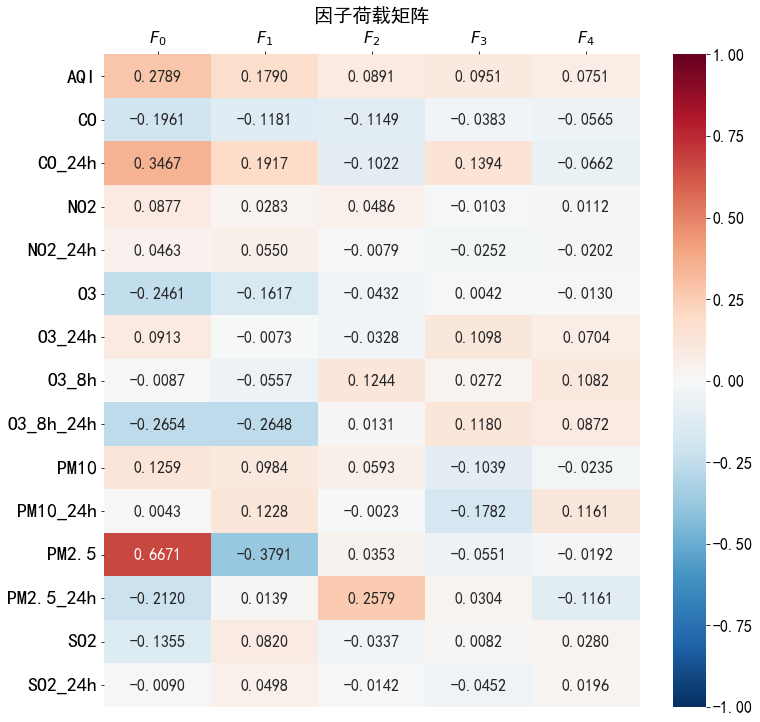

In [16]:
# 可视化
def loadingVisualization(A,title="因子荷载矩阵",size=12):
    plt.subplots(figsize=(size,size))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    xticklabels=[f"$F_{i}$" for i in range(A.shape[1])] #Latex 
    yticklabels=[f"X{i}" for i in range(A.shape[0])]
    plt.title(title)
    plt.gca().xaxis.tick_top()
    sns.heatmap(A, annot=True,vmax=1,vmin=-1, square=False,fmt=".4f", cmap='RdBu_r',yticklabels=columns,xticklabels=xticklabels,)
    plt.show()
loadingVisualization(A)

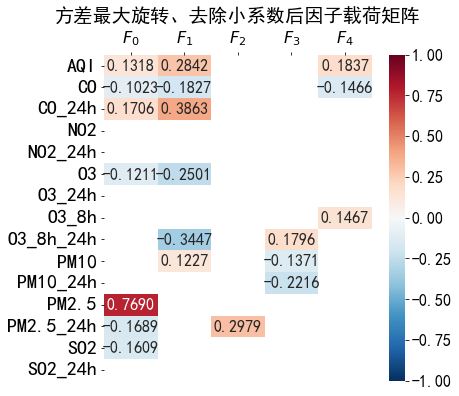

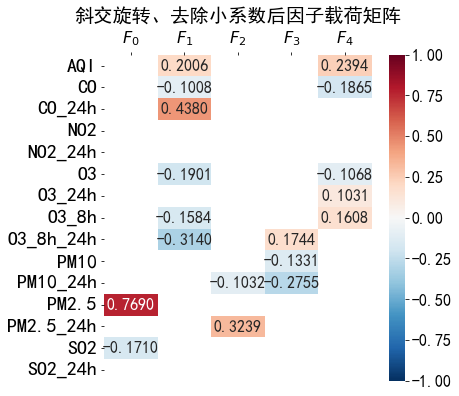

In [17]:
def varimax(loadings):
    '''
    因子分析最大方差旋转
    base from https://github.com/EducationalTestingService/factor_analyzer
    '''
    X = loadings.copy()
    n_rows, n_cols = X.shape
    if n_cols < 2:
        return X
    # initialize the rotation matrix
    # to N x N identity matrix
    rotation_mtx = np.eye(n_cols)
    d = 0
    for _ in range(1000):
        old_d = d
        # take inner product of loading matrix
        # and rotation matrix
        basis = np.dot(X, rotation_mtx)
        # transform data for singular value decomposition using updated formula :
        # B <- t(x) %*% (z^3 - z %*% diag(drop(rep(1, p) %*% z^2))/p)
        diagonal = np.diag(np.squeeze(np.repeat(1, n_rows).dot(basis**2)))
        transformed = X.T.dot(basis**3 - basis.dot(diagonal) / n_rows)
        # perform SVD on
        # the transformed matrix
        U, S, V = np.linalg.svd(transformed)
        # take inner product of U and V, and sum of S
        rotation_mtx = np.dot(U, V)
        d = np.sum(S)
        # check convergence
        if d < old_d * (1 + 1e-6):
            break
    # take inner product of loading matrix
    # and rotation matrix
    X = np.dot(X, rotation_mtx)
    new_loadings = X.copy()
    return new_loadings, rotation_mtx

def promax(loadings):
    """
    因子分析斜交旋转
    base from https://github.com/EducationalTestingService/factor_analyzer
    
    Perform promax (oblique) rotation, with optional
    Kaiser normalization.
    Parameters
    ----------
    loadings : array-like
        The loading matrix
    Returns
    -------
    loadings : numpy array, shape (n_features, n_factors)
        The loadings matrix
    rotation_mtx : numpy array, shape (n_factors, n_factors)
        The rotation matrix
    psi : numpy array or None, shape (n_factors, n_factors)
        The factor correlations
        matrix. This only exists
        if the rotation is oblique.
    """
    X = loadings.copy()
    n_rows, n_cols = X.shape
    if n_cols < 2:
        return X
    weights = X.copy()
    # first get varimax rotation
    X, rotation_mtx = varimax(weights)
    Y = X * np.abs(X)**(4 - 1)
    # fit linear regression model
    coef = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, Y))
    # calculate diagonal of inverse square
    try:
        diag_inv = np.diag(np.linalg.inv(np.dot(coef.T, coef)))
    except np.linalg.LinAlgError:
        diag_inv = np.diag(np.linalg.pinv(np.dot(coef.T, coef)))
    # transform and calculate inner products
    coef = np.dot(coef, np.diag(np.sqrt(diag_inv)))
    z = np.dot(X, coef)
    rotation_mtx = np.dot(rotation_mtx, coef)
    coef_inv = np.linalg.inv(coef)
    phi = np.dot(coef_inv, coef_inv.T)
    # convert loadings matrix to data frame
    loadings = z.copy()
    return loadings, rotation_mtx, phi


A_rotated,_,=varimax(A) #方差最大旋转
A_rotated_draw=A_rotated.copy()
A_rotated_draw[np.abs(A_rotated_draw)<0.1]=np.nan #舍去小项
loadingVisualization(A_rotated_draw,"方差最大旋转、去除小系数后因子载荷矩阵",6)


A_promax_rotated,_,_=promax(A) #斜交promax旋转
A_promax_rotated_draw=A_promax_rotated.copy()
A_promax_rotated_draw[np.abs(A_promax_rotated_draw)<0.1]=np.nan #舍去小项
loadingVisualization(A_promax_rotated_draw,"斜交旋转、去除小系数后因子载荷矩阵",6)

# 因子命名、解释
其实这个数据集找得很不好，因为没有融合其他维度的数据，例如工业耗电量、交通出行量等等其他非环境因素的维度
+ $F_0$可以认为与$PM_{2.5}$关联性很大，命名思路可以寻找$PM_{2.5}$来源
+ $F_1$可以则可以认为是CO关联性很大
+ $F_2$其实同$F_0$
+ $F_3$看不出来
+ $F_4$和臭氧相关，思路可以寻找臭氧的来源

此时可以考虑删除一些维度的变量，重新执行一次因子分析，略

# 因子得分
由于解释工作进行不顺利，后续打分其实意义不大，方法有多种，简单的写两行代码即可，复杂的import即可解决

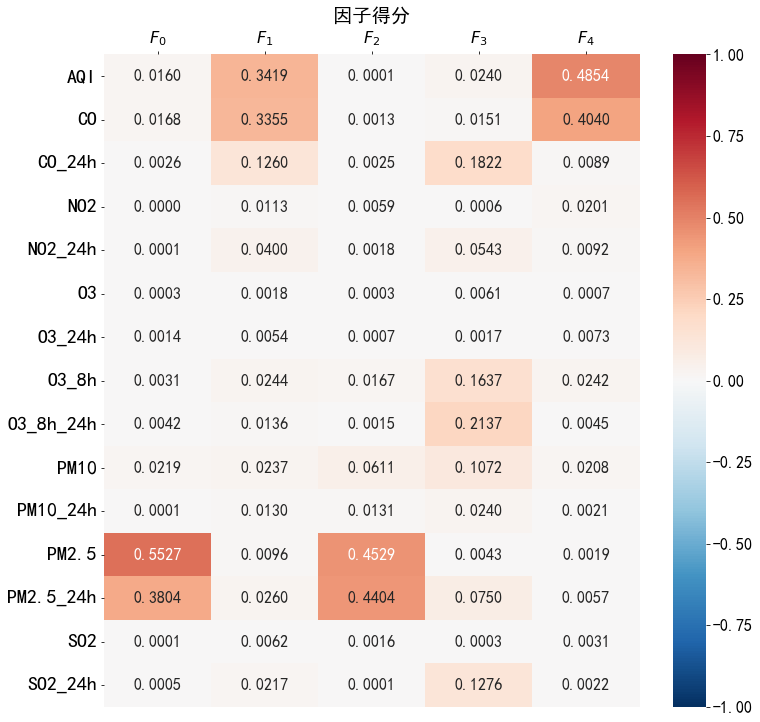

In [18]:
B=np.dot(np.linalg.inv(Xcoeff),A_promax_rotated)
B=B**2/np.sum(B**2,axis=0)
loadingVisualization(B,"因子得分")